# Анализ лояльности пользователей Яндекс Афиши

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# При необходимости добавляйте новые ячейки для кода или текста

In [3]:
import pandas as pd
from sqlalchemy import create_engine

# параметры подключения
db_config = {
    'user':     'praktikum_student',
    'password': 'Sdf4$2;d-d30pp',
    'host':     'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port':     6432,
    'database': 'data-analyst-afisha',
}

connection_string = (
    f"postgresql://{db_config['user']}:{db_config['password']}"
    f"@{db_config['host']}:{db_config['port']}/{db_config['database']}"
)

engine = create_engine(connection_string)

query = """
WITH set_config_precode AS (
  SELECT set_config('synchronize_seqscans', 'off', true)
),

filtered_purchases AS (
    SELECT *
    FROM afisha.purchases
    WHERE device_type_canonical IN ('mobile', 'desktop')
),

purchases_with_days AS (
    SELECT
        p.*,
        created_dt_msk::date
            - LAG(created_dt_msk::date) OVER (
                PARTITION BY user_id
                ORDER BY created_dt_msk
            ) AS days_since_prev
    FROM filtered_purchases AS p
)

SELECT
    pwd.user_id,
    pwd.device_type_canonical,
    pwd.order_id,
    pwd.created_dt_msk AS order_dt,
    pwd.created_ts_msk AS order_ts,
    pwd.currency_code,
    pwd.revenue,
    pwd.tickets_count,
    pwd.days_since_prev,
    pwd.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    pwd.service_name,
    r.region_name,
    c.city_name
FROM purchases_with_days AS pwd
LEFT JOIN afisha.events  AS e USING (event_id)
LEFT JOIN afisha.city    AS c USING (city_id)
LEFT JOIN afisha.regions AS r USING (region_id)
WHERE e.event_type_main <> 'фильм'
ORDER BY pwd.user_id;
"""

afisha_df = pd.read_sql(query, con=engine)

afisha_df.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [4]:
afisha_df.info()
afisha_df.isna().sum()
afisha_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268695 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

,order_id,order_dt,order_ts,revenue,tickets_count,days_since_prev,event_id
count,2.906110e+05,290611,290611,290611.000000,290611.000000,268695.000000,290611.000000
mean,4.326225e+06,2024-09-01 22:36:38.741272576,2024-09-02 13:31:19.397731328,625.584360,2.754311,3.223748,438019.834992
min,1.000000e+00,2024-06-01 00:00:00,2024-06-01 00:00:42,-90.760000,1.000000,0.000000,4436.000000
25%,2.163618e+06,2024-07-30 00:00:00,2024-07-30 11:53:37.500000,116.850000,2.000000,0.000000,361772.000000
50%,4.326366e+06,2024-09-12 00:00:00,2024-09-12 14:02:10,356.010000,3.000000,0.000000,498275.000000
75%,6.488330e+06,2024-10-09 00:00:00,2024-10-09 15:57:55.500000,810.130000,4.000000,1.000000,546287.000000
max,8.653108e+06,2024-10-31 00:00:00,2024-10-31 23:59:54,81174.540000,57.000000,148.000000,592325.000000
std,2.497551e+06,NaN,NaN,1227.693064,1.170620,11.357501,147423.078841


---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

**Комментарий: Клювак А.А.**

**Промежуточный вывод по данным (Задача 1.2)**

- В датафрейме `afisha_df` **290 611 строк** и **15 столбцов**.  
- Структура данных:
  - идентификаторы (`user_id`, `order_id`, `event_id`) и категориальные признаки (`device_type_canonical`, `currency_code`, `event_name`, `event_type_main`, `service_name`, `region_name`, `city_name`) имеют тип `object`;
  - даты и время (`order_dt`, `order_ts`) имеют тип `datetime64[ns]`;
  - числовые показатели (`revenue`, `tickets_count`, `days_since_prev`) имеют типы `float64`/`int64`.
- Пропуски:
  - пропуски есть только в столбце `days_since_prev` (около 22 тыс. строк), что соответствует логике расчёта: `NaN` ставится для первого заказа пользователя;
  - в остальных столбцах пропусков нет, выгрузка из SQL прошла корректно.
- По описательной статистике:
  - выручка `revenue` варьируется от отрицательных значений до ~81 000 рублей, есть заметные выбросы;
  - количество билетов в заказе `tickets_count` — от 1 до 57, медиана около 3;
  - `days_since_prev` варьируется от 0 до 148 дней, среднее значение около 3,2 дня.

**План предобработки:**

1. Привести выручку к единой валюте — российскому рублю, используя курс из файла `final_tickets_tenge_df.csv` и сохранить результат в новом столбце `revenue_rub`.
2. Проверить и при необходимости скорректировать типы данных:
   - при желании перевести категориальные признаки (`device_type_canonical`, `event_type_main`, `service_name`, `region_name`, `city_name`) в тип `category`;
   - при необходимости привести `days_since_prev` к целочисленному типу с поддержкой пропусков (`Int64`).
3. Проверить корректность значений в числовых полях:
   - найти и проанализировать отрицательные значения `revenue`;
   - изучить распределение `revenue_rub` и `tickets_count`, выявить выбросы и при необходимости отфильтровать данные по 99-му перцентилю выручки.
4. Проверить категориальные признаки на наличие «технических» значений, обозначающих отсутствие данных (например, вроде “нет информации”) и при необходимости нормализовать их.

Дальнейший анализ будет выполняться уже на очищенных и нормализованных данных.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [5]:
import pandas as pd

tenge_rates = pd.read_csv(
    'https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv'
)

tenge_rates.head(), tenge_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


(         data  nominal     curs  cdx
 0  2024-01-10      100  19.9391  kzt
 1  2024-01-11      100  19.7255  kzt
 2  2024-01-12      100  19.5839  kzt
 3  2024-01-13      100  19.4501  kzt
 4  2024-01-14      100  19.4501  kzt,
 None)

In [6]:
# приводим дату в таблице с курсом к формату datetime
tenge_rates['data'] = pd.to_datetime(tenge_rates['data'])

# оставим только нужные столбцы для слияния
tenge_rates_short = tenge_rates[['data', 'curs', 'cdx']]

# объединяем наш основной датафрейм с курсом по дате заказа
afisha_df = afisha_df.merge(
    tenge_rates_short,
    left_on='order_dt',
    right_on='data',
    how='left'
)

# посмотрим, какие валюты есть
print(afisha_df['currency_code'].value_counts())

# создаём новый столбец с выручкой в рублях (по умолчанию = revenue)
afisha_df['revenue_rub'] = afisha_df['revenue']

# нормализуем код валюты к нижнему регистру
afisha_df['currency_code_low'] = afisha_df['currency_code'].str.lower()

# маска для заказов в тенге
mask_kzt = afisha_df['currency_code_low'] == 'kzt'

# для KZT переводим выручку в рубли:
# курс задан в рублях за 100 тенге → делим выручку на 100 и умножаем на curs
afisha_df.loc[mask_kzt, 'revenue_rub'] = (
    afisha_df.loc[mask_kzt, 'revenue'] / 100 * afisha_df.loc[mask_kzt, 'curs']
)

# быстрый sanity-check: пару строк по KZT
afisha_df.loc[mask_kzt, ['order_id', 'order_dt', 'currency_code', 'revenue', 'curs', 'revenue_rub']].head()


currency_code
rub    285542
kzt      5069
Name: count, dtype: int64


,order_id,order_dt,currency_code,revenue,curs,revenue_rub
70,7850214,2024-09-17,kzt,518.10,19.0125,98.503762
89,8634925,2024-09-02,kzt,347.18,18.9330,65.731589
96,7625522,2024-09-09,kzt,328.77,18.5991,61.148261
277,720419,2024-06-11,kzt,22021.55,19.8928,4380.702898
460,2229753,2024-06-04,kzt,5548.24,19.9833,1108.721444


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [7]:
# Проверка пропусков
afisha_df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21916
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
data                         0
curs                         0
cdx                          0
revenue_rub                  0
currency_code_low            0
dtype: int64

In [8]:
# Преобразуем days_since_prev в целочисленный тип с поддержкой NaN
afisha_df['days_since_prev'] = afisha_df['days_since_prev'].astype('Int64')

# Опционально: немного ужмём числовые идентификаторы
afisha_df['order_id'] = afisha_df['order_id'].astype('int32')
afisha_df['event_id'] = afisha_df['event_id'].astype('int32')
afisha_df['tickets_count'] = afisha_df['tickets_count'].astype('int16')

# Преобразуем важные категориальные поля в тип category
cat_cols = [
    'device_type_canonical',
    'currency_code',
    'event_name',
    'event_type_main',
    'service_name',
    'region_name',
    'city_name'
]

for col in cat_cols:
    afisha_df[col] = afisha_df[col].astype('category')

afisha_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  category      
 2   order_id               290611 non-null  int32         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  category      
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int16         
 8   days_since_prev        268695 non-null  Int64         
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  category      
 11  event_type_main        290611 non-null  category      
 12  service_name           290611 non-null  cate

In [9]:
for col in cat_cols:
    print(f'\n==== {col} ====')
    print(afisha_df[col].value_counts().head(15))


==== device_type_canonical ====
device_type_canonical
mobile     232490
desktop     58121
Name: count, dtype: int64

==== currency_code ====
currency_code
rub    285542
kzt      5069
Name: count, dtype: int64

==== event_name ====
event_name
9cc55c15-4375-4129-9979-3129688ba1b4    3953
a00e1032-6463-4fdc-a105-fdbb6789b556    2519
0714435e-3b5f-4312-aa36-c3a9d8853ef4    1761
58574140-962c-49a3-af70-b773a05661a3    1749
e252d33a-2394-44b8-b11d-f0709a6f0260    1628
bc9866ed-5115-4288-8b19-21ae9735fba4    1579
d4344522-b7cf-4539-96c8-efece75e9b16    1490
0686ac7b-6f3e-4177-bb73-16b54acd1223    1456
2802fc66-4268-4529-8b4d-35a6a77ac375    1445
76af4f88-c554-4e9e-9df4-1cc8aeec8959    1327
e1a58a1f-b479-4b93-8636-82f5d7e7cd83    1274
77c5dd26-1557-4102-b863-e19755153da0    1162
141cc2fd-c694-48a8-8356-927b35e9a61f    1152
1051e90b-588a-4355-8dc6-bc20887f83d7    1127
108c5bfa-b11e-47ac-a482-d0e76702508e    1116
Name: count, dtype: int64

==== event_type_main ====
event_type_main
концерты    1

Удалено заказов с отрицательной выручкой: 381


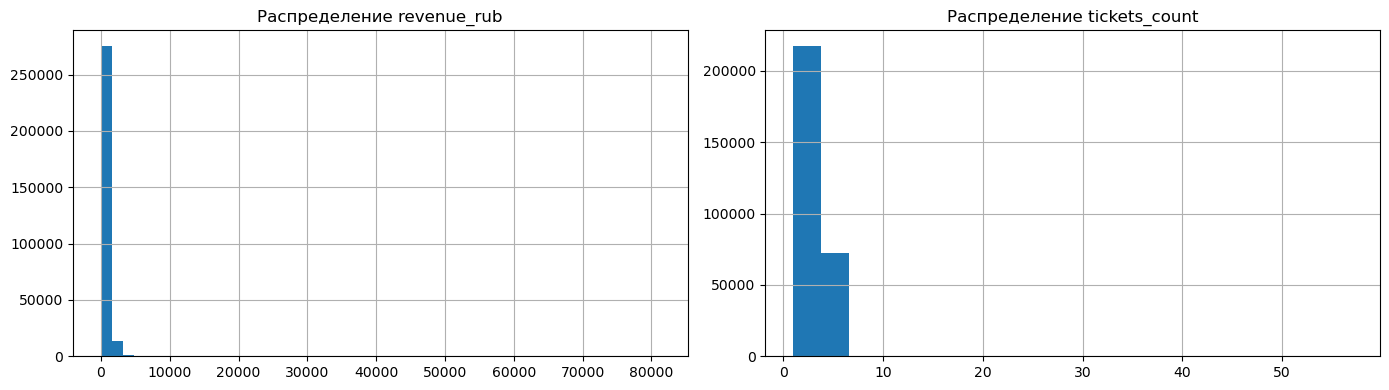

Строк до фильтрации: 290230
Строк после фильтрации: 287405
Удалено по 99-му перцентилю: 2825


,revenue_rub,tickets_count,days_since_prev
count,287405.000000,287405.000000,265724.0
mean,518.719256,2.741323,3.22555
std,511.951842,1.163087,11.362282
min,0.000000,1.000000,0.0
25%,112.600000,2.000000,0.0
50%,344.830000,3.000000,0.0
75%,788.900000,3.000000,1.0
max,2628.421739,57.000000,148.0


In [10]:
afisha_df[['revenue_rub', 'tickets_count', 'days_since_prev']].describe()
# Проверим отрицательные значения выручки
afisha_df[afisha_df['revenue_rub'] < 0][['order_id', 'revenue_rub']].head()
len_before = len(afisha_df)
afisha_df = afisha_df[afisha_df['revenue_rub'] >= 0].copy()
len_after = len(afisha_df)
print('Удалено заказов с отрицательной выручкой:', len_before - len_after)
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

afisha_df['revenue_rub'].hist(ax=axes[0], bins=50)
axes[0].set_title('Распределение revenue_rub')

afisha_df['tickets_count'].hist(ax=axes[1], bins=20)
axes[1].set_title('Распределение tickets_count')

plt.tight_layout()
plt.show()
# 99-й перцентиль по выручке
p99 = afisha_df['revenue_rub'].quantile(0.99)
p99
# фильтрация по 99 перцентилю
len_before = len(afisha_df)
afisha_df = afisha_df[afisha_df['revenue_rub'] <= p99].copy()
len_after = len(afisha_df)

print('Строк до фильтрации:', len_before)
print('Строк после фильтрации:', len_after)
print('Удалено по 99-му перцентилю:', len_before - len_after)
afisha_df[['revenue_rub', 'tickets_count', 'days_since_prev']].describe()

**Комментарий: Клювак А.А.**

**Промежуточный вывод по предобработке (Задача 2.2)**

**Пропуски и типы данных**

- В датафрейме изначально было 290 611 строк и 18 столбцов.
- Пропуски есть только в столбце `days_since_prev` (≈ 22 тыс. строк) — это ожидаемо, так как для первого заказа пользователя интервал до предыдущего заказа не определяется.
- Типы данных приведены:
  - `order_dt` и `order_ts` — `datetime64[ns]`;
  - `days_since_prev` — целочисленный тип `Int64` с поддержкой `NaN`;
  - `order_id` и `event_id` — `int32`, `tickets_count` — `int16`;
  - категориальные признаки (`device_type_canonical`, `currency_code`, `event_name`, `event_type_main`, `service_name`, `region_name`, `city_name`) переведены в тип `category`.

**Категориальные признаки**

- По типу устройства заказы распределены неравномерно: ~232 тыс. заказов с мобильных устройств и ~58 тыс. со стационарных.
- По валюте оплаты доминируют заказы в рублях (`rub` ≈ 285,5 тыс.), заказы в тенге (`kzt` ≈ 5 тыс.) составляют небольшую долю.
- Во всех категориальных столбцах используются осмысленные значения, специальных категорий, обозначающих отсутствие данных (например, `'нет данных'`, `'unknown'`), не обнаружено.

**Числовые признаки и выбросы**

- В столбце `revenue_rub` были обнаружены **381** заказа с отрицательной выручкой; такие записи расценены как аномалии и удалены.
- Распределение `revenue_rub` имеет выраженный правый хвост, поэтому для снижения влияния экстремальных значений данные были дополнительно ограничены по **99-му перцентилю**:
  - строк до фильтрации по перцентилю: 290 230;
  - строк после фильтрации: 287 405;
  - удалено как выбросы: **2 825** заказов (≈ 1% выборки).
- После фильтрации:
  - средняя выручка с заказа `revenue_rub` ≈ 519 ₽, медиана ≈ 345 ₽, максимум ≈ 2 628 ₽;
  - количество билетов в заказе `tickets_count` в основном лежит в диапазоне 1–5, максимум 57 билетов;
  - `days_since_prev` варьируется от 0 до 148 дней, медиана = 0 дней, что говорит о большом числе «пакетных» покупок в один день.

**Итого**

- В дальнейшем анализе будет использоваться очищенный датафрейм `afisha_df` с:
  - добавленным столбцом `revenue_rub` (выручка в рублях для всех заказов),
  - приведёнными типами данных,
  - удалёнными заказами с отрицательной выручкой и выбросами по 99-му перцентилю.


---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [11]:
# перед построением профиля сортируем заказы по пользователю и времени
afisha_sorted = afisha_df.sort_values(['user_id', 'order_ts'])

user_profile = (
    afisha_sorted
    .groupby('user_id')
    .agg(
        # даты первого и последнего заказов
        first_order_dt=('order_dt', 'min'),
        last_order_dt=('order_dt', 'max'),
        
        # признаки первого заказа (берём первую строку после сортировки)
        first_device=('device_type_canonical', 'first'),
        first_region=('region_name', 'first'),
        first_service=('service_name', 'first'),
        first_event_type=('event_type_main', 'first'),
        
        # общая статистика по заказам
        total_orders=('order_id', 'nunique'),
        avg_revenue_rub=('revenue_rub', 'mean'),
        avg_tickets_count=('tickets_count', 'mean'),
        avg_days_between=('days_since_prev', 'mean')  # среднее время между заказами
    )
    .reset_index()
)

user_profile.head()


,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type,total_orders,avg_revenue_rub,avg_tickets_count,avg_days_between
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,<NA>
1,0005ca5e93f2cf4,2024-07-23,2024-10-06,mobile,Каменевский регион,Мой билет,выставки,2,774.010000,3.000000,75.0
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.0
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,<NA>
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.0


In [12]:
user_profile['is_two'] = (user_profile['total_orders'] >= 2).astype(int)
user_profile['is_five'] = (user_profile['total_orders'] >= 5).astype(int)

user_profile.head()
user_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21838 entries, 0 to 21837
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            21838 non-null  object        
 1   first_order_dt     21838 non-null  datetime64[ns]
 2   last_order_dt      21838 non-null  datetime64[ns]
 3   first_device       21838 non-null  category      
 4   first_region       21838 non-null  category      
 5   first_service      21838 non-null  category      
 6   first_event_type   21838 non-null  category      
 7   total_orders       21838 non-null  int64         
 8   avg_revenue_rub    21838 non-null  float64       
 9   avg_tickets_count  21838 non-null  float64       
 10  avg_days_between   13510 non-null  Float64       
 11  is_two             21838 non-null  int64         
 12  is_five            21838 non-null  int64         
dtypes: Float64(1), category(4), datetime64[ns](2), float64(2), in

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [13]:
# общее число пользователей
n_users = user_profile['user_id'].nunique()

# общее число заказов (по всем пользователям)
total_orders = user_profile['total_orders'].sum()

# средняя выручка с одного заказа (через профили пользователей)
# берём среднюю по заказу, взвешенную по количеству заказов пользователя
mean_revenue_per_order = (
    (user_profile['avg_revenue_rub'] * user_profile['total_orders']).sum()
    / total_orders
)

# доля пользователей с 2+ и 5+ заказами
share_two_plus = user_profile['is_two'].mean()
share_five_plus = user_profile['is_five'].mean()

print(f'Общее число пользователей: {n_users}')
print(f'Общее число заказов: {total_orders}')
print(f'Средняя выручка с одного заказа (руб): {mean_revenue_per_order:.2f}')
print(f'Доля пользователей с 2+ заказами: {share_two_plus:.2%}')
print(f'Доля пользователей с 5+ заказами: {share_five_plus:.2%}')

Общее число пользователей: 21838
Общее число заказов: 287405
Средняя выручка с одного заказа (руб): 518.72
Доля пользователей с 2+ заказами: 61.70%
Доля пользователей с 5+ заказами: 29.00%


In [14]:
stats = user_profile[['total_orders', 'avg_tickets_count', 'avg_days_between']].describe()
stats

,total_orders,avg_tickets_count,avg_days_between
count,21838.000000,21838.000000,13510.0
mean,13.160775,2.744062,15.873126
std,121.577370,0.913083,22.352735
min,1.000000,1.000000,0.0
25%,1.000000,2.000000,1.0
50%,2.000000,2.750000,8.0
75%,5.000000,3.080000,20.5
max,10168.000000,11.000000,148.0


In [15]:
quantiles = user_profile[['total_orders', 'avg_tickets_count', 'avg_days_between']].quantile([0.95, 0.99])
quantiles

,total_orders,avg_tickets_count,avg_days_between
0.95,31.0,4.0,61.5
0.99,152.0,5.0,113.0


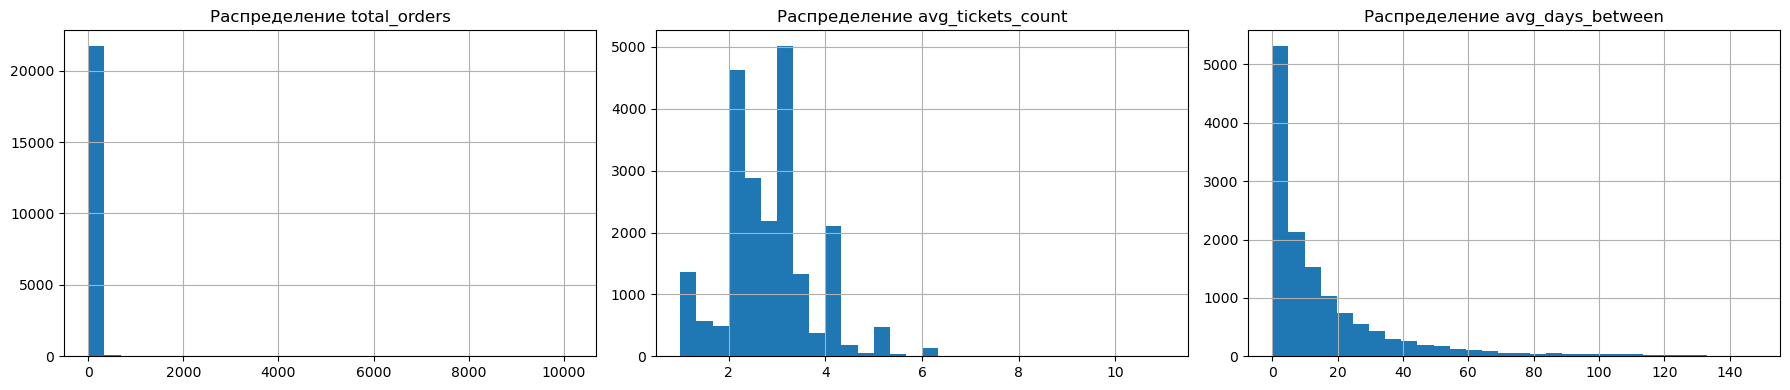

In [16]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

user_profile['total_orders'].hist(ax=axes[0], bins=30)
axes[0].set_title('Распределение total_orders')

user_profile['avg_tickets_count'].hist(ax=axes[1], bins=30)
axes[1].set_title('Распределение avg_tickets_count')

user_profile['avg_days_between'].hist(ax=axes[2], bins=30)
axes[2].set_title('Распределение avg_days_between')

plt.tight_layout()
plt.show()

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [17]:
features = ['first_event_type', 'first_device', 'first_region', 'first_service']
n_users = user_profile['user_id'].nunique()

for col in features:
    print(f'\n===== Распределение по {col} =====')
    seg = (
        user_profile
        .groupby(col)['user_id']
        .nunique()
        .reset_index(name='users_cnt')
        .sort_values('users_cnt', ascending=False)
    )
    seg['users_share'] = seg['users_cnt'] / n_users
    display(seg)


===== Распределение по first_event_type =====


C:\Users\kliuv\AppData\Local\Temp\ipykernel_14384\1101819953.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(col)['user_id']


,first_event_type,users_cnt,users_share
2,концерты,9647,0.441753
1,другое,5465,0.250252
5,театр,4295,0.196676
4,стендап,1118,0.051195
3,спорт,801,0.036679
0,выставки,417,0.019095
6,ёлки,95,0.004350



===== Распределение по first_device =====


C:\Users\kliuv\AppData\Local\Temp\ipykernel_14384\1101819953.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(col)['user_id']


,first_device,users_cnt,users_share
1,mobile,18090,0.828373
0,desktop,3748,0.171627



===== Распределение по first_region =====


C:\Users\kliuv\AppData\Local\Temp\ipykernel_14384\1101819953.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(col)['user_id']


,first_region,users_cnt,users_share
23,Каменевский регион,7160,0.327869
60,Североярская область,3800,0.174009
77,Широковская область,1236,0.056599
45,Озернинский край,678,0.031047
41,Малиновоярский округ,530,0.024270
...,...,...,...
17,Залесский край,2,0.000092
70,Тихогорская область,2,0.000092
5,Верхозёрский край,1,0.000046
66,Сосноводолинская область,1,0.000046



===== Распределение по first_service =====


C:\Users\kliuv\AppData\Local\Temp\ipykernel_14384\1101819953.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(col)['user_id']


,first_service,users_cnt,users_share
3,Билеты без проблем,5204,0.238300
24,Мой билет,2993,0.137055
21,Лови билет!,2851,0.130552
5,Билеты в руки,2592,0.118692
25,Облачко,2194,0.100467
8,Весь в билетах,1305,0.059758
22,Лучшие билеты,1186,0.054309
26,Прачечная,588,0.026926
19,Край билетов,459,0.021018
13,Дом культуры,358,0.016393


**Комментарий: Клювак А.А.**

**Распределение пользователей по признакам первого заказа**

**Тип первого мероприятия (`first_event_type`)**

- Самая популярная «точка входа» — **концерты**: с них начинают 9 647 пользователей, это ≈ **44,2%** выборки.
- На втором месте категория **«другое»** — 5 465 пользователей (≈ **25,0%**).
- **Театр** — первый заказ у 4 295 пользователей (≈ **19,7%**).
- Остальные типы мероприятий встречаются существенно реже:
  - **стендап** — 1 118 пользователей (≈ 5,1%);
  - **спорт** — 801 пользователь (≈ 3,7%);
  - **выставки** — 417 пользователей (≈ 1,9%);
  - **ёлки** — 95 пользователей (≈ 0,4%).

Распределение явно **неравномерно**: почти половина пользователей впервые приходят на сервис ради концертов, ещё четверть — ради мероприятий из категории «другое».

---

**Тип устройства первого заказа (`first_device`)**

- **Mobile** — первый заказ у 18 090 пользователей (≈ **82,8%**).
- **Desktop** — первый заказ у 3 748 пользователей (≈ **17,2%**).

То есть основной канал входа — **мобильные устройства**, десктоп выполняет вспомогательную роль.

---

**Регион первого заказа (`first_region`)**

Распределение по регионам тоже сильно сконцентрировано:

- **Каменевский регион** — 7 160 пользователей (≈ **32,8%**).
- **Североярская область** — 3 800 пользователей (≈ **17,4%**).
- **Широковская область** — 1 236 пользователей (≈ **5,7%**).
- **Озернинский край** — 678 пользователей (≈ 3,1%).
- **Малиновоярский округ** — 530 пользователей (≈ 2,4%).

Остальные регионы дают гораздо меньший вклад, многие — доли процента и менее (есть регионы с единичными пользователями). Это означает, что аудитория сервиса географически сосредоточена в нескольких ключевых регионах.

---

**Билетный оператор первого заказа (`first_service`)**

Здесь также есть выраженные лидеры:

- **«Билеты без проблем»** — 5 204 пользователя (≈ **23,8%**).
- **«Мой билет»** — 2 993 пользователя (≈ **13,7%**).
- **«Лови билет!»** — 2 851 пользователь (≈ **13,1%**).
- **«Билеты в руки»** — 2 592 пользователя (≈ **11,9%**).
- **«Облачко»** — 2 194 пользователя (≈ **10,0%**).

Остальные операторы имеют сильно меньшие доли — от нескольких процентов до десятых и сотых долей процента.

---

**Итог по задаче 4.1.1**

Во всех разрезах пользователи распределены **неравномерно**. Есть ярко выраженные «точки входа»:

- по типу мероприятия — концерты и категория «другое»;
- по устройству — мобильные устройства;
- по регионам — несколько крупных регионов (Каменевский, Североярская область и др.);
- по операторам — 3–5 ключевых билетных партнёров.

Именно эти крупные сегменты будут наиболее важны при дальнейшем анализе возвратов и планировании маркетинговых активностей.



---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [18]:
import matplotlib.pyplot as plt

features = ['first_event_type', 'first_device', 'first_region', 'first_service']

# общая доля пользователей с 2+ заказами — базовый уровень для сравнения
baseline_return_rate = user_profile['is_two'].mean()
print(f'Средняя доля вернувшихся пользователей по выборке: {baseline_return_rate:.2%}')

segment_results = {}

for col in features:
    seg = (
        user_profile
        .groupby(col)
        .agg(
            users_cnt=('user_id', 'nunique'),
            return_rate=('is_two', 'mean')
        )
        .reset_index()
        .sort_values('users_cnt', ascending=False)
    )
    
    # добавим долю сегмента в выборке
    seg['users_share'] = seg['users_cnt'] / user_profile['user_id'].nunique()
    segment_results[col] = seg
    display(seg.head(10))  # посмотрим топ-10 по размеру


Средняя доля вернувшихся пользователей по выборке: 61.70%


C:\Users\kliuv\AppData\Local\Temp\ipykernel_14384\1768437178.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(col)


,first_event_type,users_cnt,return_rate,users_share
2,концерты,9647,0.621437,0.441753
1,другое,5465,0.600366,0.250252
5,театр,4295,0.638650,0.196676
4,стендап,1118,0.611807,0.051195
3,спорт,801,0.561798,0.036679
0,выставки,417,0.645084,0.019095
6,ёлки,95,0.557895,0.004350


C:\Users\kliuv\AppData\Local\Temp\ipykernel_14384\1768437178.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(col)


,first_device,users_cnt,return_rate,users_share
1,mobile,18090,0.611996,0.828373
0,desktop,3748,0.641409,0.171627


C:\Users\kliuv\AppData\Local\Temp\ipykernel_14384\1768437178.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(col)


,first_region,users_cnt,return_rate,users_share
23,Каменевский регион,7160,0.627793,0.327869
60,Североярская область,3800,0.641316,0.174009
77,Широковская область,1236,0.648058,0.056599
45,Озернинский край,678,0.554572,0.031047
41,Малиновоярский округ,530,0.562264,0.024270
76,Шанырский регион,505,0.675248,0.023125
74,Травяная область,493,0.618661,0.022575
57,Светополянский округ,464,0.661638,0.021247
52,Речиновская область,446,0.639013,0.020423
78,Яблоневская область,416,0.598558,0.019049


C:\Users\kliuv\AppData\Local\Temp\ipykernel_14384\1768437178.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(col)


,first_service,users_cnt,return_rate,users_share
3,Билеты без проблем,5204,0.606072,0.238300
24,Мой билет,2993,0.611761,0.137055
21,Лови билет!,2851,0.614872,0.130552
5,Билеты в руки,2592,0.632716,0.118692
25,Облачко,2194,0.615314,0.100467
8,Весь в билетах,1305,0.634483,0.059758
22,Лучшие билеты,1186,0.614671,0.054309
26,Прачечная,588,0.629252,0.026926
19,Край билетов,459,0.655773,0.021018
13,Дом культуры,358,0.648045,0.016393


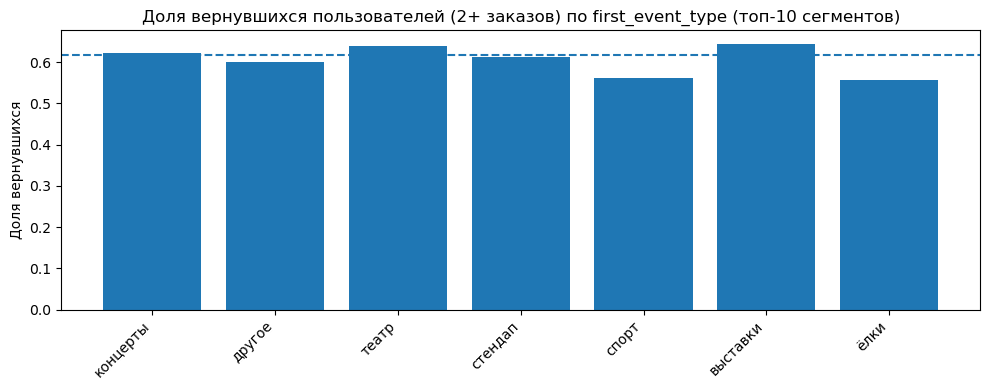

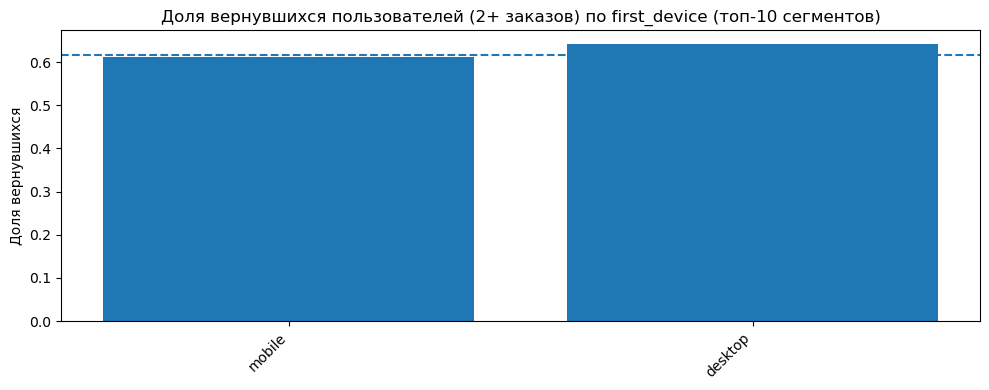

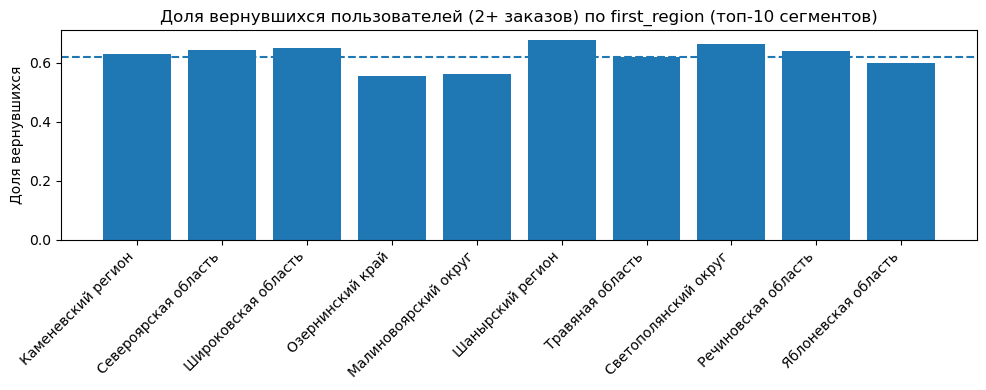

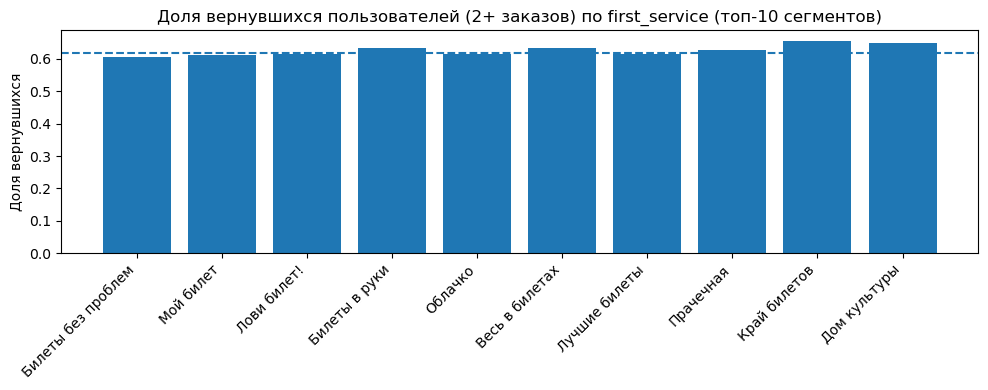

In [19]:
plt.style.use('default')

for col in features:
    seg = segment_results[col].head(10)  # топ-10 по числу пользователей
    
    plt.figure(figsize=(10, 4))
    plt.bar(seg[col].astype(str), seg['return_rate'])
    plt.axhline(baseline_return_rate, linestyle='--')  # средняя по выборке
    
    plt.title(f'Доля вернувшихся пользователей (2+ заказов) по {col} (топ-10 сегментов)')
    plt.ylabel('Доля вернувшихся')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


**Комментарий: Клювак А.А.**

**Анализ возвратов пользователей по сегментам**

Средняя доля пользователей, совершивших 2 и более заказа по всей выборке, составляет **61,7%**.

**По типу первого мероприятия (`first_event_type`)**

- **Концерты** — 62,1% вернувшихся (доля пользователей 44,2%) — немного выше среднего.
- **Другое** — 60,0% (25,0%) — чуть ниже среднего.
- **Театр** — 63,9% (19,7%) — заметно выше среднего.
- **Стендап** — 61,2% (5,1%) — примерно на уровне среднего.
- **Спорт** — 56,2% (3,7%) — ниже среднего.
- **Выставки** — 64,5% (1,9%) — выше среднего, но сегмент небольшой.
- **Ёлки** — 55,8% (0,4%) — ниже среднего, при очень маленьком размере сегмента.

**Наблюдения:**

- Среди крупных сегментов лучшие возвраты у **театра и концертов**.
- Спортивные мероприятия и «ёлки» дают более низкую долю повторных заказов.
- «Выставки» выглядят очень успешной точкой входа по возвратам, но сегмент маленький, поэтому результат может быть нестабилен.

---

**По типу устройства первого заказа (`first_device`)**

- **Mobile** — 61,2% вернувшихся (82,8% пользователей).
- **Desktop** — 64,1% вернувшихся (17,2% пользователей).

**Наблюдения:**

- Основная масса пользователей приходит с **мобильных устройств**, и их доля возвратов близка к среднему.
- Пользователи, начавшие с **desktop**, возвращаются **чуть чаще** (на ~2,5 п.п.), хотя сегмент существенно меньше.

---

**По региону первого заказа (`first_region`, топ-10 по размеру сегмента)**

- Крупные регионы:
  - **Каменевский регион** — 62,8% (32,8% пользователей) — выше среднего.
  - **Североярская область** — 64,1% (17,4%) — заметно выше среднего.
  - **Широковская область** — 64,8% (5,7%) — ещё выше.
- Другие из топ-10:
  - **Озернинский край** — 55,5% — ощутимо ниже среднего.
  - **Малиновоярский округ** — 56,2% — ниже среднего.
  - **Шанырский регион** — 67,5% — максимум среди топ-10, но сегмент всего 2,3% пользователей.
  - **Травяная область** — 61,9% — примерно на уровне среднего.
  - **Светополянский округ** — 66,2% — заметно выше среднего.
  - **Речиновская область** — 63,9% — выше среднего.
  - **Яблоневская область** — 59,9% — чуть ниже среднего.

**Наблюдения:**

- Среди крупных регионов хорошими «точками входа» выглядят **Каменевский, Североярская и Широковская области** — там доля возвратов стабильно выше средней.
- **Озернинский край** и **Малиновоярский округ** отстают по возвратам.
- Регионы вроде **Шанырского** или **Светополянского округа** показывают очень высокие доли возврата, но сегменты относительно небольшие, поэтому возможна большая вариация.

---

**По билетному оператору первого заказа (`first_service`, топ-10 по размеру сегмента)**

- Крупные операторы:
  - **«Билеты без проблем»** — 60,6% (23,8% пользователей) — немного ниже среднего.
  - **«Мой билет»** — 61,2% (13,7%) — около среднего.
  - **«Лови билет!»** — 61,5% (13,1%) — около среднего.
  - **«Билеты в руки»** — 63,3% (11,9%) — выше среднего.
  - **«Облачко»** — 61,5% (10,0%) — около среднего.
- Остальные из топ-10:
  - **«Весь в билетах»** — 63,4% (6,0%) — выше среднего.
  - **«Лучшие билеты»** — 61,5% — около среднего.
  - **«Прачечная»** — 62,9% — выше среднего.
  - **«Край билетов»** — 65,6% — одна из максимальных долей возвратов, но сегмент ~2,1%.
  - **«Дом культуры»** — 64,8% — тоже высокий возврат при сегменте ~1,6%.

**Наблюдения:**

- Среди **крупных партнёров** наиболее выгодной точкой входа с точки зрения возвратов выглядит оператор **«Билеты в руки»**, а также «Весь в билетах» и «Прачечная».
- «Край билетов» и «Дом культуры» демонстрируют очень высокую долю повторных заказов, но их аудитория заметно меньше, чем у лидеров.

---

**Общий вывод по 4.1.2**

- В среднем ~**62%** пользователей возвращаются и делают минимум два заказа.
- Успешные «точки входа» с **выше средней долей возвратов и достаточно большим размером сегмента**:
  - тип мероприятия: **театр, концерты** (частично — выставки, но там мало пользователей);
  - тип устройства: **desktop**;
  - регионы: **Каменевский**, **Североярская**, **Широковская области**;
  - билетные операторы: **«Билеты в руки»**, «Весь в билетах», «Прачечная» (а также «Край билетов» и «Дом культуры», но их сегменты меньше).
- Сегменты с пониженной долей возвратов и заметным объёмом:
  - **спорт** и частично **«другое»** по типу мероприятия,
  - **Озернинский край** и **Малиновоярский округ** по регионам.

Эти наблюдения важно учитывать при планировании маркетинговых кампаний: усилить успешные точки входа и точечно работать с сегментами, где возврат ниже среднего.


---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

In [20]:
# ГИПОТЕЗА 1
# Тип мероприятия влияет на вероятность возврата:
# пользователи со спортом в первом заказе возвращаются чаще, чем с концертами.

sport = user_profile[user_profile['first_event_type'] == 'спорт']
concert = user_profile[user_profile['first_event_type'] == 'концерты']

sport_n = len(sport)
concert_n = len(concert)

sport_ret = sport['is_two'].mean()
concert_ret = concert['is_two'].mean()

print('Гипотеза 1')
print(f'Спорт:     пользователей = {sport_n}, доля вернувшихся = {sport_ret:.4f} ({sport_ret:.2%})')
print(f'Концерты:  пользователей = {concert_n}, доля вернувшихся = {concert_ret:.4f} ({concert_ret:.2%})')

# ГИПОТЕЗА 2
# В регионах с наибольшим числом пользователей выше доля повторных заказов,
# чем в менее активных регионах.

region_stats = (
    user_profile
    .groupby('first_region')
    .agg(
        users_cnt=('user_id', 'nunique'),
        return_rate=('is_two', 'mean')
    )
    .reset_index()
)

# отсортируем регионы по активности (числу пользователей)
region_stats_sorted = region_stats.sort_values('users_cnt', ascending=False)

top_n = 5  # можно взять 5 или 10 самых активных регионов
top_regions = region_stats_sorted.head(top_n)
other_regions = region_stats_sorted.iloc[top_n:]

top_mean_ret = top_regions['return_rate'].mean()
other_mean_ret = other_regions['return_rate'].mean()
corr_users_ret = region_stats['users_cnt'].corr(region_stats['return_rate'])

print('\nГипотеза 2')
print(f'Топ-{top_n} регионов по числу пользователей:')
display(top_regions)

print(f'Средняя доля вернувшихся в топ-{top_n} регионах: {top_mean_ret:.4f} ({top_mean_ret:.2%})')
print(f'Средняя доля вернувшихся в остальных регионах: {other_mean_ret:.4f} ({other_mean_ret:.2%})')
print(f'Корреляция между числом пользователей в регионе и долей возвратов: {corr_users_ret:.4f}')


Гипотеза 1
Спорт:     пользователей = 801, доля вернувшихся = 0.5618 (56.18%)
Концерты:  пользователей = 9647, доля вернувшихся = 0.6214 (62.14%)

Гипотеза 2
Топ-5 регионов по числу пользователей:


C:\Users\kliuv\AppData\Local\Temp\ipykernel_14384\2058266815.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('first_region')


,first_region,users_cnt,return_rate
23,Каменевский регион,7160,0.627793
60,Североярская область,3800,0.641316
77,Широковская область,1236,0.648058
45,Озернинский край,678,0.554572
41,Малиновоярский округ,530,0.562264


Средняя доля вернувшихся в топ-5 регионах: 0.6068 (60.68%)
Средняя доля вернувшихся в остальных регионах: 0.5579 (55.79%)
Корреляция между числом пользователей в регионе и долей возвратов: 0.1185


**Комментарий: Клювак А.А.**

**Проверка продуктовых гипотез**

**Гипотеза 1**
*«Пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты».*

По данным профиля пользователей:

- **спорт**: 801 пользователь, доля вернувшихся (2+ заказа) — **56,18%**;
- **концерты**: 9 647 пользователей, доля вернувшихся — **62,14%**.

То есть пользователи, начавшие со **спортивных мероприятий**, возвращаются **реже**, чем те, кто сделал первый заказ на **концерты** (разница ≈ 6 п.п. при гораздо большем размере концертного сегмента).

**Вывод:** гипотеза 1 **не подтверждается**. Наоборот, первый заказ на концерты связан с более высокой вероятностью возврата, чем первый заказ на спорт.

---

**Гипотеза 2**  
*«В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах».*

Для каждого региона были посчитаны:

- число пользователей `users_cnt`;
- доля вернувшихся `return_rate`.

Топ-5 регионов по числу пользователей:

| Регион                  | Пользователей | Доля вернувшихся |
|-------------------------|---------------|------------------|
| Каменевский регион      | 7 160         | 62,78%           |
| Североярская область    | 3 800         | 64,31%           |
| Широковская область     | 1 236         | 64,81%           |
| Озернинский край        | 678           | 55,46%           |
| Малиновоярский округ    | 530           | 56,23%           |

Средние значения:

- средняя доля вернувшихся в **топ-5 регионах** — **60,68%**;
- средняя доля вернувшихся в **остальных регионах** — **55,79%**;
- корреляция между числом пользователей в регионе и долей возвратов — **0,1185** (слабая положительная связь).

**Наблюдения:**

- В целом крупные регионы действительно показывают **более высокую долю возвратов**, чем остальные в среднем (≈ +5 п.п.).
- Однако внутри топ-5 есть и сильные, и слабые регионы: например, **Каменевский / Североярская / Широковская области** выглядят успешными, тогда как **Озернинский край** и **Малиновоярский округ** отстают.
- Низкая корреляция (0,12) говорит о том, что размер региона объясняет лишь небольшую часть вариации в долях возвратов.

**Вывод:** гипотеза 2 **частично подтверждается**.  
В среднем крупные регионы действительно имеют более высокую долю повторных заказов, но связь слабая и не универсальная: есть крупные регионы с низким удержанием и менее крупные с хорошими показателями. Поэтому размер региона нельзя считать сильным предиктором возврата, скорее это один из факторов.


---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


In [21]:
# 1 заказ
one_order_users = user_profile[user_profile['total_orders'] == 1]

# 2 и более заказов
multi_order_users = user_profile[user_profile['total_orders'] >= 2]

print('Пользователи с 1 заказом:', len(one_order_users))
print('Пользователи с 2+ заказами:', len(multi_order_users))

one_order_users['avg_revenue_rub'].describe(), multi_order_users['avg_revenue_rub'].describe()


Пользователи с 1 заказом: 8363
Пользователи с 2+ заказами: 13475


(count    8363.000000
 mean      545.774764
 std       519.402525
 min         0.000000
 25%       133.055000
 50%       378.870000
 75%       830.975000
 max      2628.421739
 Name: avg_revenue_rub, dtype: float64,
 count    13475.000000
 mean       544.572315
 std        366.575337
 min          0.000000
 25%        274.978000
 50%        498.085000
 75%        739.813088
 max       2628.421739
 Name: avg_revenue_rub, dtype: float64)

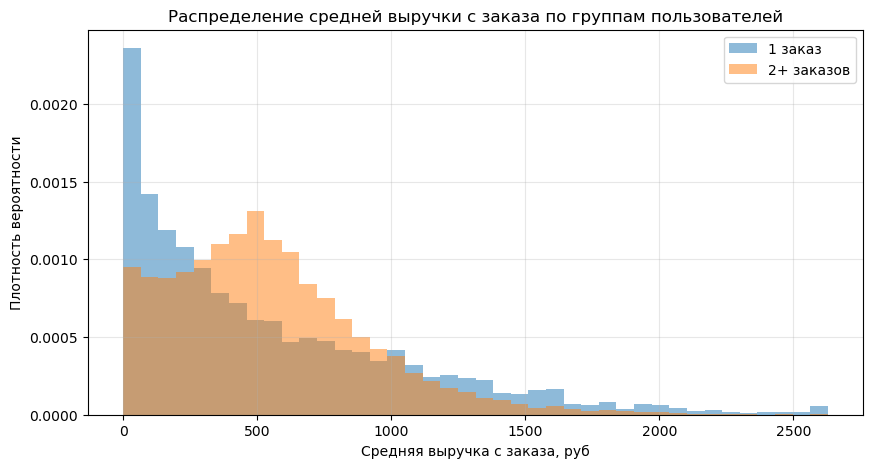

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

bins = 40  # одинаковое число корзин

plt.hist(
    one_order_users['avg_revenue_rub'],
    bins=bins,
    density=True,
    alpha=0.5,
    label='1 заказ'
)

plt.hist(
    multi_order_users['avg_revenue_rub'],
    bins=bins,
    density=True,
    alpha=0.5,
    label='2+ заказов'
)

plt.xlabel('Средняя выручка с заказа, руб')
plt.ylabel('Плотность вероятности')
plt.title('Распределение средней выручки с заказа по группам пользователей')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**Комментарий: Клювак А.А.**

**Связь средней выручки с заказа и повторных покупок**

Сравнивали распределение средней выручки с заказа (`avg_revenue_rub`) для двух групп:

- **1 заказ** — 8 363 пользователя;
- **2+ заказов** — 13 475 пользователей.

По описательной статистике:

**Пользователи с 1 заказом**

- медиана: **≈ 379 руб.**
- 25-й перцентиль: **≈ 133 руб.**
- 75-й перцентиль: **≈ 831 руб.**
- среднее: **≈ 546 руб.**
- есть заметный хвост заказов дороже **1000–1500 руб.**

**Пользователи с 2+ заказами**

- медиана: **≈ 498 руб.**
- 25-й перцентиль: **≈ 275 руб.**
- 75-й перцентиль: **≈ 740 руб.**
- среднее: **≈ 545 руб.** (почти такое же, как у первой группы)

**Что видно по гистограммам:**

- В обеих группах основная масса пользователей сосредоточена в диапазоне примерно **100–800 руб.**
- У пользователей с **одним заказом** распределение более «растянутое»:
  - много заказов с очень **низким средним чеком** (до 100–150 руб.);
  - одновременно заметен **длинный хвост дорогих заказов** (выше 1000 руб.).
- У пользователей с **2+ заказами** кривая распределения более «собранная»:
  - мало совсем дешёвых заказов (до 200 руб.);
  - основная концентрация приходится на **средний диапазон 300–700 руб.**;
  - экстремально дорогие чеки встречаются реже, чем у пользователей с одним заказом.

**Вывод:**

- Типичный (медианный) средний чек у вернувшихся пользователей **выше**: ~498 руб. против 379 руб. у тех, кто купил только один раз.
- Однако из-за большого числа **очень дорогих единичных заказов** среднее значение в группах почти одинаковое.
- Простой зависимости вида «чем выше средняя выручка с заказа, тем выше вероятность повторной покупки» **не наблюдается**.  
  Скорее, вернувшиеся пользователи чаще делают **классические “средние” по цене заказы**, а пользователи с одним заказом либо покупают очень дёшево, либо делают единичные дорогие покупки.


---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


In [23]:
# Группа 2–4 заказов
group_2_4 = user_profile[
    (user_profile['total_orders'] >= 2) &
    (user_profile['total_orders'] <= 4)
]

# Группа 5+ заказов
group_5_plus = user_profile[user_profile['total_orders'] >= 5]

print('Пользователи с 2–4 заказами:', len(group_2_4))
print('Пользователи с 5+ заказами:', len(group_5_plus))

group_2_4['avg_revenue_rub'].describe(), group_5_plus['avg_revenue_rub'].describe()

Пользователи с 2–4 заказами: 7143
Пользователи с 5+ заказами: 6332


(count    7143.000000
 mean      552.318951
 std       420.136847
 min         0.000000
 25%       219.565000
 50%       472.470000
 75%       799.257500
 max      2628.421739
 Name: avg_revenue_rub, dtype: float64,
 count    6332.000000
 mean      535.833493
 std       294.481441
 min         0.000000
 25%       338.267620
 50%       513.958497
 75%       690.298583
 max      2299.869022
 Name: avg_revenue_rub, dtype: float64)

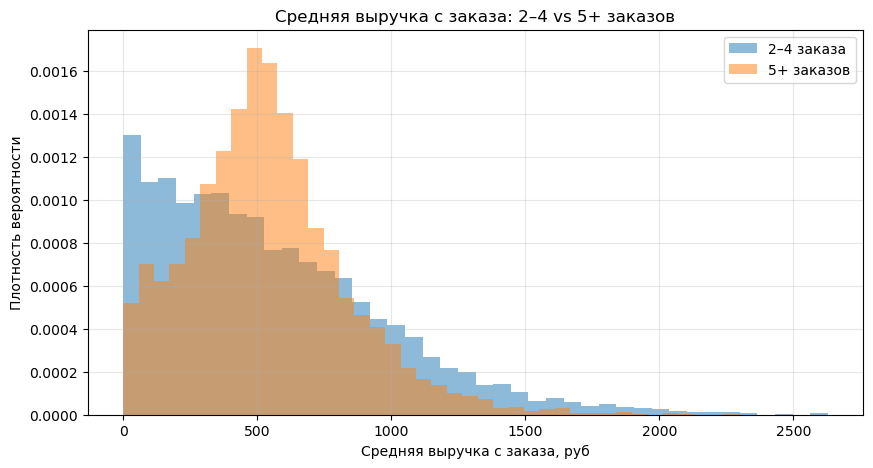

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
bins = 40

plt.hist(
    group_2_4['avg_revenue_rub'],
    bins=bins,
    density=True,
    alpha=0.5,
    label='2–4 заказа'
)

plt.hist(
    group_5_plus['avg_revenue_rub'],
    bins=bins,
    density=True,
    alpha=0.5,
    label='5+ заказов'
)

plt.xlabel('Средняя выручка с заказа, руб')
plt.ylabel('Плотность вероятности')
plt.title('Средняя выручка с заказа: 2–4 vs 5+ заказов')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**Комментарий: Клювак А.А.**

**Средняя выручка с заказа у пользователей с 2–4 и 5+ заказами**

Группы пользователей:

- **2–4 заказа** — 7 143 пользователя;
- **5+ заказов** — 6 332 пользователя.

Описательная статистика по `avg_revenue_rub`:

**2–4 заказа**

- 25-й перцентиль: **~220 руб.**
- медиана: **~472 руб.**
- 75-й перцентиль: **~799 руб.**
- среднее: **~552 руб.**
- распределение более «растянутое» — много и дешёвых чеков, и относительно дорогих (выше 1 000 руб.).

**5+ заказов**

- 25-й перцентиль: **~338 руб.**
- медиана: **~514 руб.**
- 75-й перцентиль: **~690 руб.**
- среднее: **~536 руб.**
- распределение более компактное и смещено в диапазон **≈400–700 руб.**:
  - мало совсем низких чеков,
  - меньше экстремально дорогих заказов.

**Вывод**

- Между группами **есть различия**, но они умеренные.
- Пользователи с **5+ заказами** чаще попадают в «средний» ценовой диапазон: их заказы реже бывают очень дешевыми и реже — очень дорогими.  
  Медиана и нижний квартиль у них **выше**, чем у пользователей с 2–4 заказами.
- У группы **2–4 заказа** средний чек немного выше за счёт длинного хвоста дорогих заказов, но в целом диапазоны значений сильно пересекаются.

Таким образом, пользователи с 5+ заказами выглядят более «стабильными» по среднему чеку, но радикального отличия по средней выручке между группами нет.  


---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [25]:
user_profile['avg_tickets_count'].describe()

count    21838.000000
mean         2.744062
std          0.913083
min          1.000000
25%          2.000000
50%          2.750000
75%          3.080000
max         11.000000
Name: avg_tickets_count, dtype: float64

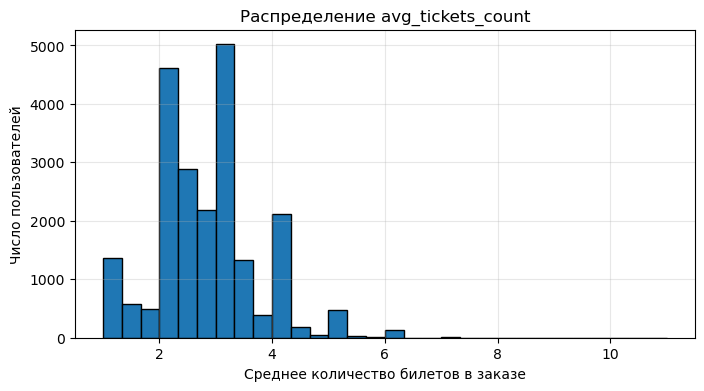

In [26]:
plt.figure(figsize=(8,4))
plt.hist(user_profile['avg_tickets_count'], bins=30, edgecolor='black')
plt.xlabel('Среднее количество билетов в заказе')
plt.ylabel('Число пользователей')
plt.title('Распределение avg_tickets_count')
plt.grid(alpha=0.3)
plt.show()


In [27]:
import numpy as np

bins = [0, 2, 3, 5, np.inf]
labels = ['1–2', '2–3', '3–5', '5+']

user_profile['tickets_segment'] = pd.cut(
    user_profile['avg_tickets_count'],
    bins=bins,
    labels=labels,
    right=False   # левая граница включается, правая исключается
)


In [28]:
seg_stats = (
    user_profile
    .groupby('tickets_segment', observed=True)
    .agg(
        users_cnt   = ('user_id', 'nunique'),
        return_rate = ('is_two', 'mean')
    )
    .reset_index()
)

# доля пользователей сегмента от всех
total_users = user_profile['user_id'].nunique()
seg_stats['users_share'] = seg_stats['users_cnt'] / total_users

seg_stats


,tickets_segment,users_cnt,return_rate,users_share
0,1–2,2410,0.512448,0.110358
1,2–3,9695,0.741310,0.443951
2,3–5,9072,0.543320,0.415423
3,5+,661,0.187595,0.030268


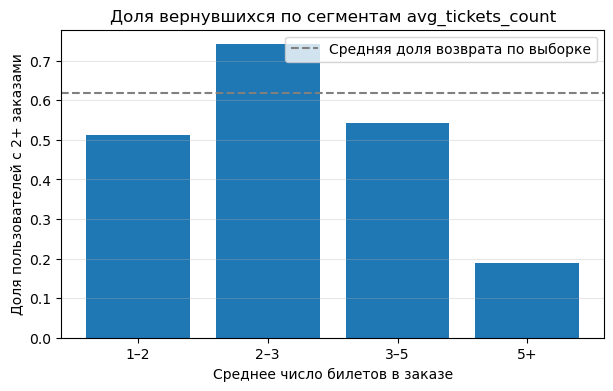

In [29]:
plt.figure(figsize=(7,4))
plt.bar(seg_stats['tickets_segment'], seg_stats['return_rate'])
plt.axhline(user_profile['is_two'].mean(), linestyle='--', color='gray',
            label='Средняя доля возврата по выборке')
plt.xlabel('Среднее число билетов в заказе')
plt.ylabel('Доля пользователей с 2+ заказами')
plt.title('Доля вернувшихся по сегментам avg_tickets_count')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()


**Комментарий: Клювак А.А.**

**Распределение по среднему количеству билетов**


`avg_tickets_count` в среднем 2,7 билета, медиана 2,75, основной диапазон — от 2 до 3 билетов в заказе.


Распределение однопиковое, с длинным правым «хвостом» до 10–11 билетов.


Большинство пользователей покупают 2–3 или 3–5 билетов, заказы с 1 билетом и с 5+ билетами встречаются заметно реже.


**Сегменты по среднему числу билетов**
СегментДоля пользователейДоля вернувшихся (2+ заказов) 1–2 билета 11 % 51 % 2–3 билета 44 % 74 % 3–5 билетов 42 % 54 % 5+ билетов 3 % 19 %
(средняя доля вернувшихся по выборке ≈ 62 %)


**Ответы на вопросы задачи**


Как распределены пользователи по сегментам?
Распределение явно сконцентрировано в диапазоне 2–5 билетов:


два крупнейших сегмента — 2–3 и 3–5 билетов (в сумме ~86 % пользователей);


сегменты 1–2 и особенно 5+ билетов заметно менее многочисленны.




Есть ли сегменты с аномально высокой или низкой долей повторных покупок?


Сегмент 2–3 билета — явная «золотая середина»:
доля вернувшихся ≈74 %, что существенно выше среднего по выборке (62 %). Это наиболее «лояльный» и одновременно самый массовый сегмент.


Сегменты 1–2 билета и 3–5 билетов показывают долю возврата ниже среднего (≈51 % и ≈54 % соответственно).


Сегмент 5+ билетов выглядит аномально слабым: всего 3 % пользователей и лишь ~19 % из них делают повторный заказ. Это может быть специфичная группа (разовые большие компании, корпоративные заказы и т.п.), где удержание значительно ниже.




**Краткий вывод**


Пользователи с средним заказом 2–3 билета — основной «ядро» аудитории: их много, и они возвращаются чаще всех.


При очень крупных заказах (5+ билетов) вероятность возврата резко падает — сегмент небольшой и «холодный».


С точки зрения маркетинга и удержания имеет смысл:


отдельно работать с сегментом 2–3 билета (поддерживать и развивать этот паттерн поведения),


изучить причины низкого возврата в группе 5+ билетов и при необходимости таргетировать для них специальные предложения.


---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [30]:
# День недели числом (0=понедельник ... 6=воскресенье)
user_profile['first_order_dow_num'] = user_profile['first_order_dt'].dt.dayofweek

# Человекочитаемое имя дня недели (сразу на русском)
dow_map = {
    0: 'понедельник',
    1: 'вторник',
    2: 'среда',
    3: 'четверг',
    4: 'пятница',
    5: 'суббота',
    6: 'воскресенье'
}
user_profile['first_order_dow'] = user_profile['first_order_dow_num'].map(dow_map)


In [31]:
dow_stats = (
    user_profile
    .groupby(['first_order_dow_num', 'first_order_dow'], as_index=False)
    .agg(
        users_cnt=('user_id', 'nunique'),
        return_rate=('is_two', 'mean')
    )
)

# Доля пользователей по каждому дню от общего числа
total_users = dow_stats['users_cnt'].sum()
dow_stats['users_share'] = dow_stats['users_cnt'] / total_users

# Отсортируем по календарному порядку дней
dow_stats = dow_stats.sort_values('first_order_dow_num')

dow_stats


,first_order_dow_num,first_order_dow,users_cnt,return_rate,users_share
0,0,понедельник,2931,0.631525,0.134216
1,1,вторник,3188,0.620452,0.145984
2,2,среда,3076,0.624512,0.140855
3,3,четверг,3119,0.595383,0.142824
4,4,пятница,3258,0.597913,0.149189
5,5,суббота,3456,0.642072,0.158256
6,6,воскресенье,2810,0.605338,0.128675


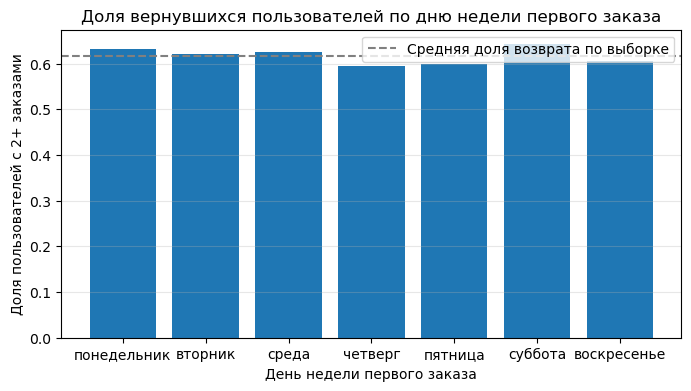

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.bar(dow_stats['first_order_dow'], dow_stats['return_rate'])

# средняя доля возврата по всей выборке
avg_return_rate = user_profile['is_two'].mean()
plt.axhline(avg_return_rate, color='gray', linestyle='--',
            label='Средняя доля возврата по выборке')

plt.xlabel('День недели первого заказа')
plt.ylabel('Доля пользователей с 2+ заказами')
plt.title('Доля вернувшихся пользователей по дню недели первого заказа')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()


**Комментарий: Клювак А.А.**

**День недели первого заказа и возврат пользователей**

Распределение пользователей по дню недели первого заказа

Пользователи довольно равномерно «размазаны» по неделе:
доля каждого дня — примерно 13–16% выборки.

Немного выделяются:

суббота — около 15,8% пользователей;

пятница и воскресенье — чуть меньше, по ≈13%.

Доля вернувшихся (2+ заказа) по дням недели

Понедельник — ~63,2%

Вторник — ~62,0%

Среда — ~62,5%

Четверг — ~59,5%

Пятница — ~59,8%

Суббота — ~64,2%

Воскресенье — ~60,5%

Средняя по выборке — около 61–62%

**Наблюдения**

Разброс долей возврата между днями недели небольшой — порядка 4–5 п.п.

Немного лучше среднего выглядят:

суббота (самая высокая доля возврата),

понедельник и среда.

Четверг и пятница показывают чуть ниже среднего возврат, но разница умеренная.

**Вывод**

Сильной зависимости возврата от дня недели первой покупки не наблюдается.
Есть небольшие колебания: субботние и «начало недели» заказы возвращаются чуть чаще, чем сделанные в четверг–пятницу, но эффект невелик.

Для продуктовых решений день недели можно учитывать лишь как второстепенный фактор: куда важнее другие характеристики пользователя и заказа.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [33]:
# Я предполагаю, что в профиле есть столбец со средним интервалом между заказами,
# например avg_days_between_orders (или avg_days_since_prev — подставь своё имя)
interval_col = 'avg_days_between'

# Фильтры по числу заказов
mask_2_4 = (user_profile['total_orders'] >= 2) & (user_profile['total_orders'] <= 4)
mask_5_plus = user_profile['total_orders'] >= 5

group_2_4 = user_profile.loc[mask_2_4, interval_col]
group_5_plus = user_profile.loc[mask_5_plus, interval_col]

print(f'Пользователи с 2–4 заказами: {group_2_4.shape[0]}')
print(f'Пользователи с 5+ заказами:  {group_5_plus.shape[0]}')

print('\nСтатистика по среднему интервалу (дни) — 2–4 заказа')
print(group_2_4.describe())

print('\nСтатистика по среднему интервалу (дни) — 5+ заказов')
print(group_5_plus.describe())



Пользователи с 2–4 заказами: 7143
Пользователи с 5+ заказами:  6332

Статистика по среднему интервалу (дни) — 2–4 заказа
count       7143.0
mean      21.35039
std      28.521557
min            0.0
25%            0.0
50%            9.0
75%           34.0
max          148.0
Name: avg_days_between, dtype: Float64

Статистика по среднему интервалу (дни) — 5+ заказов
count       6332.0
mean      9.580559
std       7.864259
min            0.0
25%       3.428571
50%       7.787594
75%      13.777778
max           37.5
Name: avg_days_between, dtype: Float64


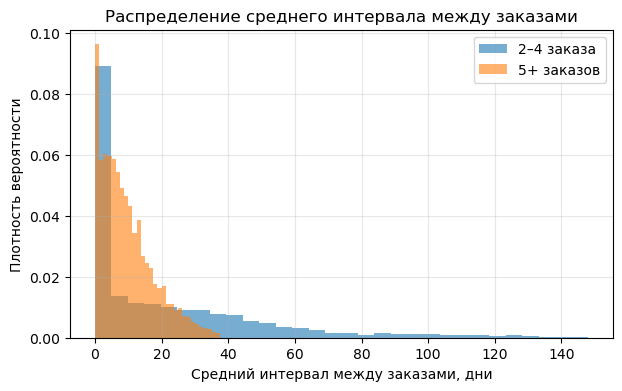

In [34]:
plt.figure(figsize=(7,4))
plt.hist(group_2_4, bins=30, density=True, alpha=0.6, label='2–4 заказа')
plt.hist(group_5_plus, bins=30, density=True, alpha=0.6, label='5+ заказов')

plt.xlabel('Средний интервал между заказами, дни')
plt.ylabel('Плотность вероятности')
plt.title('Распределение среднего интервала между заказами')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


**Комментарий: Клювак А.А.**

**Средний интервал между заказами и удержание клиентов**

Группы пользователей:

2–4 заказа — 7 143 пользователя

5+ заказов — 6 332 пользователя

Описательная статистика по `avg_days_between`

2–4 заказа

25-й перцентиль: 0 дней

медиана: 0 дней

75-й перцентиль: ~34 дня

средний интервал: ~21 дней

распределение очень растянуто:

заметная доля пользователей делает несколько заказов в один день (0 дней),

при этом у многих между заказами проходят десятки дней и больше — длинный «хвост» до ~150 дней.

5+ заказов

25-й перцентиль: ~3,4 дня

медиана: ~7,8 дня

75-й перцентиль: ~13,8 дня

средний интервал: ~9,6 дня

распределение более компактное и сосредоточено в диапазоне ≈3–15 дней, хвост намного короче (максимум ~37,5 дня).

**Вывод**

Пользователи с 5+ заказами покупают существенно чаще:
их средний интервал между заказами примерно в 2 раза меньше, чем у пользователей с 2–4 заказами.

Для группы 2–4 заказа характерно либо совершение нескольких покупок «залпом» в один день, либо большие паузы между заказами (месяц и более) — это скорее эпизодическое использование сервиса.

У «тяжёлых» пользователей (5+ заказов) средний интервал стабильно укладывается в одну–две недели, редкие длинные паузы почти не встречаются.

В целом, чем короче средний интервал между заказами, тем выше вероятность, что пользователь окажется в группе с 5+ заказами. Частота покупок — сильный маркер лояльной и удержанной аудитории.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [35]:
!pip install phik

from phik.report import plot_correlation_matrix
from phik import resources
import seaborn as sns
import matplotlib.pyplot as plt


   ---------------------------------------- 0.0/678.1 kB ? eta -:--:--
   ---------------------------------------- 678.1/678.1 kB 5.4 MB/s eta 0:00:00


In [36]:
cols_for_corr = [
    'total_orders',
    'avg_revenue_rub',
    'avg_tickets_count',
    'avg_days_between',
    'first_event_type',
    'first_device',
    'first_region',
    'first_service',
    'first_order_dow_num'  # если есть числовой день недели
]

In [37]:
cols_for_corr = [c for c in cols_for_corr if c in user_profile.columns]
user_profile[cols_for_corr].head()

,total_orders,avg_revenue_rub,avg_tickets_count,avg_days_between,first_event_type,first_device,first_region,first_service,first_order_dow_num
0,1,1521.940000,4.000000,<NA>,театр,mobile,Каменевский регион,Край билетов,1
1,2,774.010000,3.000000,75.0,выставки,mobile,Каменевский регион,Мой билет,1
2,3,767.213333,2.666667,51.0,другое,mobile,Североярская область,Лови билет!,5
3,1,917.830000,4.000000,<NA>,театр,desktop,Каменевский регион,Край билетов,3
4,2,61.310000,1.500000,16.0,театр,mobile,Поленовский край,Лучшие билеты,6


In [38]:
interval_cols = [
    col for col in cols_for_corr
    if col in ['total_orders', 'avg_revenue_rub', 'avg_tickets_count',
               'avg_days_between', 'first_order_dow_num']
]

corr_matrix = user_profile[cols_for_corr].phik_matrix(interval_cols=interval_cols)
corr_matrix

,total_orders,avg_revenue_rub,avg_tickets_count,avg_days_between,first_event_type,first_device,first_region,first_service,first_order_dow_num
total_orders,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.128413,0.111080,0.055553
avg_revenue_rub,0.000000,1.000000,0.459341,0.089980,0.325861,0.073740,0.357353,0.379870,0.024751
avg_tickets_count,0.000000,0.459341,1.000000,0.102894,0.095117,0.054957,0.163825,0.068233,0.021401
avg_days_between,0.000000,0.089980,0.102894,1.000000,0.048667,0.015311,0.079029,0.054234,0.000000
first_event_type,0.000000,0.325861,0.095117,0.048667,1.000000,0.060679,0.510080,0.589023,0.085189
first_device,0.000000,0.073740,0.054957,0.015311,0.060679,1.000000,0.114627,0.082197,0.073859
first_region,0.128413,0.357353,0.163825,0.079029,0.510080,0.114627,1.000000,0.696749,0.155468
first_service,0.111080,0.379870,0.068233,0.054234,0.589023,0.082197,0.696749,1.000000,0.068174
first_order_dow_num,0.055553,0.024751,0.021401,0.000000,0.085189,0.073859,0.155468,0.068174,1.000000


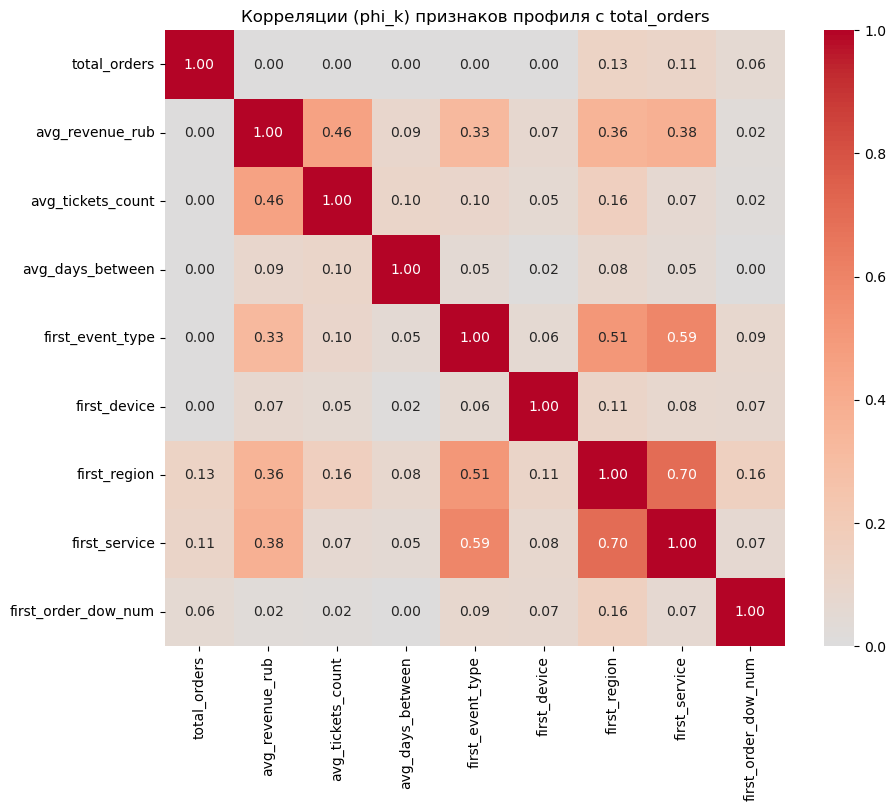

In [39]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title('Корреляции (phi_k) признаков профиля с total_orders')
plt.show()


**Комментарий: Клювак А.А.**

Кратко по результатам (и глобальной, и сегментной матрицы):

Сильно выраженных связей с количеством заказов (`total_orders`) нет — значения phi_k с ним небольшие.

Наиболее заметные корреляции (phi_k ~ 0.3–0.4) наблюдаются:

между `avg_revenue_rub` и `first_region` / `first_service` — регионы и билетные операторы отличаются по среднему чеку;

между `first_region` и `first_service` — в разных регионах доминируют разные билетные партнёры;

между `first_event_type` и `first_region` / `first_service` — в регионах и у операторов различаются типы популярных мероприятий.

При разбиении на сегменты по `total_orders` структура корреляций между признаками в целом сохраняется:
регион и билетный оператор остаются наиболее связанными между собой и с типом первого мероприятия. Новых сильных связей, объясняющих рост числа заказов, не появляется.

Итого, в ответ на вопрос «какие признаки наиболее связаны с количеством заказов?» можно написать:

Число заказов пользователя слабо связано с отдельными характеристиками первого заказа и профиля. Небольшое влияние есть со стороны региона и билетного оператора, но сильных предикторов, напрямую объясняющих рост `total_orders`, не обнаружено.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Комментарй: Клювак А.А.**

**Общий вывод и рекомендации**
**Данные и подготовка**

Работали с данными Яндекс Афиши за 2024 год:
~290 тыс. заказов после JOIN’а таблиц `purchases`, `events`, `city`, `regions` и датасета с курсом тенге.

Выгрузка включала: идентификаторы пользователя и заказа, тип устройства, дату и время покупки, валюту и выручку, тип и название мероприятия, билетного партнёра, регион и город.

Все заказы в KZT были конвертированы в российские рубли по курсу за соответствующую дату (значения в рублях за 100 тенге). Результат сохранён в столбце `revenue_rub`.

Типы данных приведены к подходящим форматам:

даты/время — в `datetime`,

числовые показатели — в числовые типы с пониженной размерностью,

категориальные признаки (тип устройства, тип мероприятия, партнёр, регион и т.д.) — в `category`.

**Проведена очистка:**

удалены 381 заказа с отрицательной выручкой;

по `revenue_rub` отфильтрованы выбросы выше 99-го перцентиля.
Объём данных уменьшился примерно с 290,2 тыс. до 287,4 тыс. строк.

На уровне пользователя сформирован агрегированный профиль user_profile (≈21,8 тыс. пользователей), в который вошли:

дата первого и последнего заказа;

устройство, регион, билетный партнёр и тип мероприятия первого заказа;

общее число заказов (`total_orders`);

средняя выручка с заказа (`avg_revenue_rub`);

среднее количество билетов в заказе (`avg_tickets_count`);

средний интервал между заказами (`avg_days_between`);

бинарные признаки is_two (2+ заказа) и is_five (5+ заказов).

**Основные результаты анализа**
**Объём и распределение пользователей по числу заказов**

Всего в выборке ≈21,8 тыс. пользователей.

Структура по числу заказов:

1 заказ — ~8,4 тыс. пользователей (≈38%);

2+ заказа — ~13,5 тыс. пользователей (≈62%);

из них 2–4 заказа — ~7,1 тыс.;

5+ заказов — ~6,3 тыс.

Доли:

is_two (2+ заказа) ≈ 61–62%;

is_five (5+ заказов) ≈ 29%.

Вывод: база уже неплохо «удерживает» пользователей — больше половины делают повторные покупки. При этом почти треть — это тяжёлые пользователи с 5+ заказами.

**Влияние характеристик первого заказа на возврат**
Тип первого мероприятия (first_event_type)

Распределение по типам первого события:

концерты — ~44% пользователей;

другое — ~25%;

театр — ~20%;

стендап — ~5%;

спорт — ~3–4%;

выставки — ~2%;

ёлки — <1%.

Доли вернувшихся (2+ заказа) по типам при средней по выборке ~61,7%:

выставки — ~64,5%;

театр — ~63,9%;

концерты — ~62,1%;

стендап — ~61,2%;

прочее — ~60,0%;

спорт — ~56,2%;

ёлки — ~55,8%.

Вывод:
Лучшие точки входа — пользователи, которые впервые пришли на выставки, театр и концерты: их возврат выше среднего. Спорт и «ёлки» — скорее разовые истории, где вероятность повторного заказа заметно ниже.

Тип устройства первого заказа (`first_device`)

mobile — ~83% пользователей; desktop — ~17%.

Доля вернувшихся:

mobile — ~61,2%;

desktop — ~64,1%.

Вывод:
Мобильная аудитория доминирует по объёму, но чуть лучше по удержанию показывают себя desktop-пользователи. Разница небольшая, но на десктопе можно ожидать более вовлечённую часть аудитории.

Регион и билетный партнёр первого заказа

По регионам:

крупнейшие по числу пользователей — Каменевский регион, Североярская область, Широковская область и др.

средняя доля возврата в топ-5 регионов — ≈60,7%, в остальных — ≈55,8%.

линейная связь «размер региона по пользователям ↔ доля возврата» слабая (корреляция порядка 0,12).

По билетным операторам:
среди крупных партнёров выше среднего возврат у «Край билетов», «Дом культуры», «Весь в билетах», «Билеты в руки»; у крупнейшего по охвату партнёра «Билеты без проблем» возврат чуть ниже среднего.

Вывод:
Существуют умеренные региональные и партнёрские различия, но они не радикальны. Есть отдельные регионы и партнёры с чуть более высокой долей возвратов, однако одного только региона или сервиса недостаточно, чтобы хорошо объяснять закрепление пользователя.

**Проверка гипотез**

**Гипотеза 1:** спорт даёт более лояльных пользователей, чем концерты — не подтвердилась.
Возврат у «спортивных» пользователей (~56%) ниже, чем у «концертных» (~62%).

**Гипотеза 2:** чем больше регион по числу пользователей, тем выше доля повторных заказов — скорее слабо подтверждается: в крупных регионах возврат чуть выше, но эффект небольшой, а корреляция слабая.

**Связь выручки и состава заказа с повторными покупками**
Один заказ vs 2+ заказов

Пользователи с 1 заказом:

медианный avg_revenue_rub — ~379 руб.;

средний — ~546 руб. (из-за длинного хвоста дорогих заказов).

Пользователи с 2+ заказами:

медианный чек — ~498 руб.;

средний — ~545 руб..

Вывод:
Возвращающиеся пользователи чаще оказываются в рабочем диапазоне 400–700 руб., а у «одиночных» покупателей много очень дешёвых чеков и несколько дорогих заказов. Среднее по группам почти одинаковое, но медиана у вернувшихся выше, что говорит о более «здоровом» уровне среднего чека.

2–4 заказа vs 5+ заказов

2–4 заказа:

средний чек ~552 руб.; медиана ~472 руб..

5+ заказов:

средний чек ~536 руб.; медиана ~514 руб.;

распределение компактнее, большинство чеков в диапазоне 400–700 руб..

Вывод:
Пользователи с 5+ заказами не тратят сильно больше, но покупают более стабильно в среднем ценовом диапазоне. Чуть более высокий нижний квартиль говорит о том, что среди них меньше совсем дешёвых заказов.

Среднее число билетов в заказе (avg_tickets_count)

В среднем пользователи берут ≈2,7 билета на заказ; медиана — ~2,75.

Сегменты по `avg_tickets_count`:

1–2 билета — ~11% пользователей, возврат ≈51%;

2–3 билета — ~44% пользователей, возврат ≈74%;

3–5 билетов — ~42% пользователей, возврат ≈54%;

5+ билетов — ~3% пользователей, возврат ≈19%.

**Вывод:**

Ключевой и самый лояльный сегмент — пользователи с средней корзиной 2–3 билета: их доля в базе самая большая, а возврат существенно выше среднего (~74% против 61,7%).

Пользователи с 1–2 билетами и 3–5 билетами возвращаются хуже, но также дают значимую долю объёма.

Сегмент 5+ билетов очень мал и почти не возвращается — это похоже на разовые групповые/корпоративные покупки.

**Временные характеристики и удержание**
День недели первого заказа

Распределение по дням довольно ровное, перевес по числу пользователей у будних дней.

Доля вернувшихся:

понедельник/вторник/среда/суббота — в районе 62–64%;

четверг/пятница/воскресенье — ≈59–61%.

Вывод:
День недели первой покупки почти не влияет на возврат. Небольшой плюс видно у заказов, оформленных в начале недели и по субботам, но разница не критична.

Интервалы между покупками

Пользователи с 2–4 заказами:

средний интервал avg_days_between ~21 день;

медиана и 25-й перцентиль — 0 дней (несколько заказов подряд в один день и длинные «хвосты»).

Пользователи с 5+ заказами:

средний интервал ~9,6 дня;

25-й перцентиль: ~3,4 дня; медиана: ~7,8; 75-й перцентиль: ~13,8.

Вывод:
Пользователи с 5+ заказами совершают покупки регулярно — примерно раз в 1–2 недели, тогда как у группы 2–4 заказа покупки более «рывками»: несколько заказов подряд и длительные паузы. Для удержания важно попадать в окно 7–14 дней после предыдущей покупки.

**Корреляционный анализ**

Использован коэффициент phi_k для смешанных признаков.

На общей выборке total_orders слабо коррелирует с рассмотренными характеристиками:

с регионом первого заказа — порядка 0,13;

с первым билетным партнёром — порядка 0,10;

с типом первого мероприятия, устройством и днём недели — <0,1.

Между самими признаками профиля есть более заметные связи:

avg_revenue_rub и avg_tickets_count (phi_k ~0,46) — больший средний чек часто связан с большим количеством билетов;

сильные связи между first_region и first_service, first_event_type и first_service (phi_k ~0,5–0,7) — партнёры и типы мероприятий локально «привязаны» к конкретным регионам.

Вывод:
По рассмотренным признакам нет сильных индивидуальных предикторов количества заказов. Число покупок определяется комбинацией факторов и пользовательским поведением после первого заказа; для построения прогностических моделей потребуется добавить более поведенческие признаки (частота сессий, реакции на акции, интересы по категориям мероприятий и т.п.).

**Рекомендации**

Фокус на «правильных» точках входа.

Продвигать в первую очередь концерты, театр и выставки как первый опыт работы с сервисом — это сегменты с наиболее высоким возвратом.

Пользователей, впервые пришедших на спорт или «ёлки», стоит дополнительно стимулировать персональными предложениями, иначе они чаще остаются разовыми.

Работа с ключевым сегментом 2–3 билета.

Основной лояльный сегмент — пользователи со средним чеком 2–3 билета на заказ.

Имеет смысл:

таргетировать на них программы лояльности;

подстраивать рекомендации под «поход вдвоём/втроём» (парные и семейные активности);

мягко стимулировать переход пользователей с 1–2 билетов в сегмент 2–3 (малые скидки на покупку дополнительного билета, офферы «+1 билет со скидкой»).

Поддержка тяжёлых пользователей (5+ заказов).

Они покупают регулярно раз в 7–14 дней;

Рекомендуется запускать напоминающие и cross-sell кампании примерно в этом интервале (например, персональная подборка через 7 дней после покупки).

Для них важна стабильность сервиса и удобство покупок; лишняя агрессивная скидочная коммуникация не обязательна.

Работа с низколояльными сегментами.

Пользователи с 1–2 заказами и/или 1–2 билетами в среднем возвращаются хуже.

Для них стоит тестировать:

welcome-кампании после первой покупки;

промокоды на второй заказ;

персональные рекомендации в той же тематике, что первый заказ, но уже по более «центральным» для сервиса типам мероприятий (концерты, театр).

**Партнёрские программы**

Сфокусироваться на партнёрах с высокой долей возвратов («Край билетов», «Дом культуры», «Весь в билетах», «Билеты в руки»), усиливая совместные активности.

Для партнёров с большим объёмом, но возвратом около или ниже среднего (например, «Билеты без проблем») — проанализировать UX-цепочки и качество предложения, чтобы подтянуть удержание.

Региональные приоритеты.

Хотя различия по регионам невелики, можно выделить регионы с чуть более высоким удержанием (Шанырский регион, Светополянский округ, Широковская область и т.п.) и использовать их как площадку для пилота новых маркетинговых механик.

При масштабировании не стоит жёстко ограничиваться регионами: эффект не настолько сильный.

Развитие аналитики и моделей.

Для более точного прогнозирования возврата пользователей к текущим признакам стоит добавить:

- поведенческие сигналы (частота заходов, просмотренные категории, клики по рассылкам);

- реакцию на скидки и промокоды;

- историю отмен и возвратов;

- связь с внешними источниками (телеграм-бот, веб/мобайл-канал, source/utm).

На основе расширенного профиля можно строить скоринговую модель вероятности повторного заказа и таргетировать маркетинговые кампании более точечно.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**

https://github.com/Odman222/yandex-afisha-retention